In [1]:
from ib_insync import *
import pandas as pd
from datetime import datetime, timedelta
import requests
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [2]:
util.startLoop()

In [ ]:
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)


<IB connected to 127.0.0.1:7497 clientId=1>

Peer closed connection.


In [4]:
# Definir el contrato para la acción de GOOGL
contract = Stock('GOOGL', 'SMART', 'USD')

In [5]:
# Establecer el rango de tiempo
end_time = datetime.now()
start_time = end_time - timedelta(days=90)

In [6]:
# Obtener datos históricos
bars = ib.reqHistoricalData(
    contract,
    endDateTime=end_time,
    durationStr='90 D',
    barSizeSetting='1 hour',
    whatToShow='TRADES',
    useRTH=False
)


In [7]:

# Convertir los datos a DataFrame
df = util.df(bars)

In [8]:
# Obtener noticias relevantes sobre GOOGL
API_KEY = 'b35c56d955ee45178c703f7f79c1dfca'
news_url = f'https://newsapi.org/v2/everything?q=Google%20OR%20Alphabet%20OR%20NASDAQ%20GOOGL&apiKey={API_KEY}'
response = requests.get(news_url)
news_data = response.json()

In [9]:
titles = [article['title'] for article in news_data['articles']]
print(f"Titulares de noticias relevantes:\n {titles}")

Titulares de noticias relevantes:
 ['Google Co-Founder Says Employees Should Be In The Office "At Least" Every Weekday As Competition In The AI Arms Race Intensifies', 'Google and Apple found in violation of EU law', 'Nvidia stock falls 6% into a correction as the Nasdaq bleeds', "Here's how much Big Tech wants to spend on AI this year", "Google's Gemini Live will now be able to access your camera and screen", 'Nvidia, Google, Tesla, BYD, Tencent Music, Xpeng: Stocks to watch today', "Google's AI chatbot will use your search history to get more personal", "Google's biggest buy ever", "Google now lets you delete your personal information from search. Here's how", 'D-WAVE QUANTUM Stock Rises 62% Post Q4 Results: To Buy or Not to Buy?', 'The Dow drops 550 points as Trump shrugs off a market rout and says more tariffs are coming', 'Apple faces a DEI backlash', 'Apple shareholders just rejected a proposal to end DEI efforts', 'Alphabet (GOOGL) Reaffirmed as ‘Outperform’ as Google AI Strengt

In [10]:
# Análisis de sentimiento de noticias
positive_keywords = ['rise', 'growth', 'record', 'profit']
negative_keywords = ['fall', 'loss', 'decline', 'drop']


In [11]:
positive_news = sum(1 for title in titles if any(word in title.lower() for word in positive_keywords))
negative_news = sum(1 for title in titles if any(word in title.lower() for word in negative_keywords))
impact_factor = 1 + (positive_news - negative_news) * 0.001

In [12]:
# Seleccionar datos y normalizar
data = df[['open', 'high', 'low', 'close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data_adjusted = scaled_data * impact_factor


In [13]:
# Identificar soportes y resistencias
def find_support_resistance(data):
    levels = []
    for i in range(2, len(data) - 2):
        if data[i] < data[i - 1] and data[i] < data[i + 1]:
            levels.append((i, data[i]))  # Soporte
        elif data[i] > data[i - 1] and data[i] > data[i + 1]:
            levels.append((i, data[i]))  # Resistencia
    return levels

support_resistance_levels = find_support_resistance(df['close'].values)
print(f"Niveles de soporte y resistencia detectados: {support_resistance_levels}")

Niveles de soporte y resistencia detectados: [(2, np.float64(179.4)), (3, np.float64(179.97)), (6, np.float64(178.33)), (7, np.float64(179.08)), (8, np.float64(178.91)), (10, np.float64(179.22)), (11, np.float64(178.4)), (13, np.float64(178.5)), (14, np.float64(178.4)), (16, np.float64(178.7)), (17, np.float64(178.19)), (23, np.float64(179.94)), (24, np.float64(179.9)), (27, np.float64(180.37)), (33, np.float64(179.44)), (34, np.float64(180.0)), (35, np.float64(179.7)), (37, np.float64(181.78)), (38, np.float64(179.74)), (42, np.float64(182.03)), (43, np.float64(181.59)), (44, np.float64(181.69)), (54, np.float64(179.28)), (55, np.float64(179.46)), (56, np.float64(179.35)), (57, np.float64(179.88)), (60, np.float64(178.9)), (61, np.float64(178.94)), (62, np.float64(178.89)), (64, np.float64(179.0)), (65, np.float64(178.84)), (66, np.float64(178.94)), (71, np.float64(174.59)), (72, np.float64(175.13)), (73, np.float64(174.8)), (75, np.float64(175.6)), (77, np.float64(175.1)), (78, np.fl

In [14]:
# Crear secuencias de datos para LSTM
sequence_length = 60
x_train, y_train = [], []
for i in range(sequence_length, len(scaled_data_adjusted)):
    x_train.append(scaled_data_adjusted[i-sequence_length:i])
    y_train.append(scaled_data_adjusted[i])

x_train, y_train = np.array(x_train), np.array(y_train)

In [15]:
# Definir modelo LSTM
model = Sequential()
model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=4))

# Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1041
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0092
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0081
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0078
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0066
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0060
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0063
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0056
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0055
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0050
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0053
Epoch 12/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0048
Epoch 13/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0044
Epoch 14/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0044
Epoch 15/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0045
Epoc

In [16]:
# Predicciones
recent_data = scaled_data_adjusted[-sequence_length:]
predictions = []
for _ in range(10):
    x_input = np.array([recent_data])
    predicted_price = model.predict(x_input)
    predictions.append(predicted_price[0])
    recent_data = np.append(recent_data[1:], [predicted_price[0]], axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [17]:
# Desnormalizar predicciones
predictions = scaler.inverse_transform(predictions)
prediction_times = [end_time.replace(hour=8, minute=0, second=0) + timedelta(hours=i) for i in range(1, 11)]
predicted_df = pd.DataFrame(predictions, columns=['open', 'high', 'low', 'close'], index=prediction_times)
print(predicted_df)

                                  open        high         low       close
2025-03-21 09:00:00.042845  162.290704  162.975618  161.589392  162.220934
2025-03-21 10:00:00.042845  162.213936  162.885964  161.508444  162.143296
2025-03-21 11:00:00.042845  162.185335  162.838525  161.475455  162.116955
2025-03-21 12:00:00.042845  162.187654  162.820751  161.473229  162.122188
2025-03-21 13:00:00.042845  162.209840  162.823859  161.490936  162.146914
2025-03-21 14:00:00.042845  162.244795  162.841723  161.521702  162.183724
2025-03-21 15:00:00.042845  162.287959  162.870073  161.561132  162.228072
2025-03-21 16:00:00.042845  162.336407  162.905935  161.606390  162.277162
2025-03-21 17:00:00.042845  162.388272  162.947224  161.655630  162.329271
2025-03-21 18:00:00.042845  162.442361  162.992471  161.707638  162.383334


In [18]:
import matplotlib.pyplot as plt

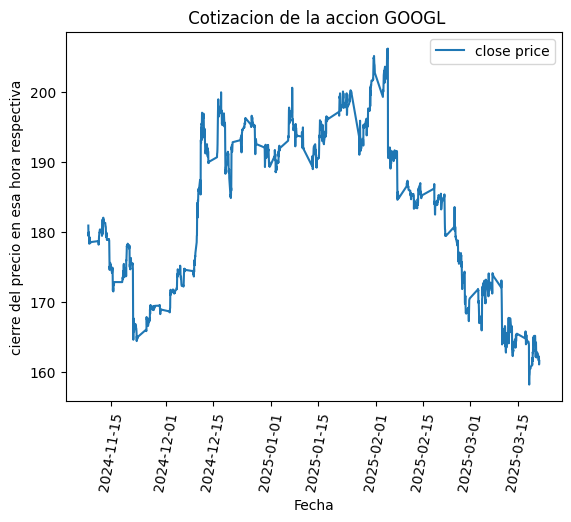

In [19]:
plt.Figure(figsize=(10, 8))
plt.plot(df['date'], df['close'], label='close price')


#Le ponemos titulos al mapa que tenemos
plt.title(' Cotizacion de la accion GOOGL')
plt.xlabel('Fecha')
plt.ylabel('cierre del precio en esa hora respectiva')
plt.xticks(rotation = 80)
plt.legend()

plt.show()

In [20]:
ib.disconnect()